# Create multliayer Food groups 
It is a copy of Multilayer food_groups.ipynb but that I am going to mess-up to tranform into a code that I can apply to make trajectories of a country across the years

In [1]:
import pandas as pd
import numpy as np
import time
import networkx as nx
import geopandas as gpd # pip installed
import matplotlib.pyplot as plt 
import pickle

In [2]:
def Edge_overlap_w(data,weight):
    """Calculate the weighted edge overlap for each 'origin_country_ISO' in a DataFrame.

    In weighted multilayer networks the edge overlap is the sum of all the weights of all out-links in each node.  

    Parameters:
    - data (pd.DataFrame): Input DataFrame containing at least the 'origin_country_ISO' and 'value' columns.

    Returns:
    pd.DataFrame: DataFrame with edge overlap calculated for each 'origin_country_ISO'.
    The output DataFrame has one column named 'overlap' representing the calculated edge overlap weights.

    Example:
    >>> df_result = Edge_overlap_w(input_data)
    """
    if weight==True:
        overlap_w= data.groupby(['origin_country_ISO']).apply(lambda group : group.value.sum())
    else:
        overlap_w= data.groupby(['origin_country_ISO']).apply(lambda group : len(group))

    overlap_w= pd.DataFrame(overlap_w.sort_values(ascending=False),columns=['o_i'])
    return overlap_w

def Node_strength_w(data):
    """ Calculate the node relevance in each layer of the multilayer network. 
    In a weighted directed network the country strenght is the sum of the magnitude exported by that country in that layer.

    Parameters:
    - data (pd.DataFrame): Input DataFrame containing trade data for a single year. The dataframe must contain 
    the columns: 'item', 'unit', 'origin_country_ISO', and 'value'.

    Returns:
    pd.DataFrame: DataFrame with country strength for each combination of 'item' and 'unit', sorted from highest to lowest. 
    Columns include 'Food_group', 'unit', 'origin_country_ISO', and the calculated 'value' for node strength.

    Example:
    >>> df_result = Node_strength_w(input_data)
    """

    str_i_l = data.groupby(['Food_group','unit']).apply(lambda group: group.loc[:,['origin_country_ISO','value']].
                                                        pivot_table(index='origin_country_ISO', aggfunc='sum').
                                                        sort_values(by = 'value',ascending=False))
    # Reset multi-index:
    strength_i_l= str_i_l.reset_index(level=['Food_group','unit','origin_country_ISO']).rename(columns={'value':'str_i_l'})

    return strength_i_l
    
def Node_strength(data, weight = True):
    """ Calculate the node relevance in each layer of the multilayer network. 
    In a weighted directed network the country strenght is the sum of the magnitude exported by that country in that layer.

    Parameters:
    - data (pd.DataFrame): Input DataFrame containing trade data for a single year. The dataframe must contain 
    the columns: 'item', 'unit', 'origin_country_ISO', and 'value'.

    Returns:
    pd.DataFrame: DataFrame with country strength for each combination of 'item' and 'unit', sorted from highest to lowest. 
    Columns include 'item', 'unit', 'origin_country_ISO', and the calculated 'value' for node strength.

    Example:
    >>> df_result = Node_strength_w(input_data)
    """
    
    if (weight==True):
        str_i_l = data.groupby(['item','unit']).apply(lambda group: group.loc[:,['origin_country_ISO','value']].
                                                        pivot_table(index='origin_country_ISO', aggfunc='sum').
                                                        sort_values(by = 'value',ascending=False))
        strength_i_l= str_i_l.reset_index(level=['item','unit','origin_country_ISO']).rename(columns={'value':'str_i_l'})

    else:
        str_i_l = data.groupby(['item','unit']).apply(lambda group: group.loc[:,['origin_country_ISO','value']].
                                                        pivot_table(index='origin_country_ISO', aggfunc=lambda x: len(x.unique())).
                                                        sort_values(by = 'value',ascending=False))
        strength_i_l= str_i_l.reset_index(level=['item','unit','origin_country_ISO']).rename(columns={'value':'str_i_l'})

    return strength_i_l
    
def Participation_coeff_old (data,overlap):

    #Define elements for part_coeff
    L = len(data.Food_group.unique())

    
    s_i_l = Node_strength_w(data)

    # Prepare data
    data_for_Pc = pd.merge(s_i_l, overlap.loc[:,['country','overl']], left_on= 'origin_country_ISO',right_on='country', how='left')


    # Contibution of each layer to total exports
    data_for_Pc['sum_layers'] = (data_for_Pc['str_i_l']/data_for_Pc['overl'])**2
    
    sum_layers= data_for_Pc.groupby(['origin_country_ISO']).apply(lambda group: group.sum_layers.sum())

    particip_coeff =  pd.DataFrame((L/(L-1))*(1- sum_layers),columns=['partic_coeff']).sort_values(by='partic_coeff',ascending=False)
    return particip_coeff 
  
def Participation_coeff (data, overlap, direction, weight=True):

    if (weight == True):
        w_f = '_w'
        flag_overlap = 'overl'
    else:
        w_f = ''
        flag_overlap = 'deg'

    #Define elements for part_coeff
    L = len(data.item.unique())
    
    s_i_l = Node_strength(data,weight)

    # Prepare data
    #data_for_Pc = pd.merge(s_i_l, o_i, left_on= 'origin_country_ISO',right_index=True, how='left')
    data_for_Pc = pd.merge(s_i_l, overlap.loc[:,['country',direction+'_'+flag_overlap]], left_on= 'origin_country_ISO',right_on='country', how='left')

    # Contibution of each layer to total exports:
    data_for_Pc['sum_layers'] = (data_for_Pc['str_i_l']/data_for_Pc[direction+'_'+flag_overlap])**2
    
    sum_layers= data_for_Pc.groupby(['origin_country_ISO']).apply(lambda group: group.sum_layers.sum())

    particip_coeff = (pd.DataFrame((L/(L-1))*(1- sum_layers),columns=['pc'+w_f+'_'+direction]).
                      sort_values(by='pc'+w_f+'_'+direction,ascending=False))
    return particip_coeff 


def Agregated_network (edge_data,node_info, group_class):

    # General network 
    pos_dict = node_info.loc[:,['ISO','pos','name']].set_index('ISO').to_dict(orient='index')
    pos_dict

    edge_dict =dict(zip(zip(edge_data['origin_country_ISO'], edge_data['destin_country_ISO'], edge_data[group_class]), edge_data['value']))
    edge_dict

    # Create network
    G=nx.MultiDiGraph()

    G.add_nodes_from(pos_dict)
    nx.set_node_attributes(G,pos_dict)

    G.add_edges_from(edge_dict.keys())
    nx.set_edge_attributes(G, edge_dict, 'weight')
    nx.set_edge_attributes(G, edge_dict.keys(), '<attribute_name>')
    return G
        

def Make_dict_years (data_in, year_check):
    """ 
    Iterate everything to filter data per year, get network and network stats. 
    The output should be a the dataframe with the value of overlap and zscore for each country the year being explored. 

    This will be saved in a dictionary. 
    """
    print(year_check)
    # Load data 
    data_filt = data_in.loc[(data_in.unit =='1000 US$') & (data_in.year == year_check) & (data_in.value > 0) ,:].copy()

    # Create agregated multilayer network 
    G = Agregated_network(data_filt, country_metadata, group_class = group_class)
    
    # Degree estimations
    out_degree= pd.DataFrame([i for i in G.out_degree()],columns=['country','out_deg']).sort_values(by='out_deg',ascending=False)
    in_degree= pd.DataFrame([i for i in G.in_degree()],columns=['country','in_deg']).sort_values(by='in_deg',ascending=False)

    # Overlap: sum of weights (out_degree)
    overlap= pd.DataFrame([i for i in G.out_degree(weight='weight')],columns=['country','out_overl']).sort_values(by='out_overl',ascending=False)
    in_overlap= pd.DataFrame([i for i in G.in_degree(weight='weight')],columns=['country','in_overl']).sort_values(by='in_overl',ascending=False)

    overlap= pd.merge(overlap,in_overlap, on='country', copy=False)
    overlap= pd.merge(overlap,out_degree, on='country', copy=False)
    overlap= pd.merge(overlap,in_degree, on='country', copy=False)

    # Add z score degree and overlap:
    overlap['z_'+direction+'_deg'] = (overlap[direction+'_deg'] - overlap[direction+'_deg'].mean())/overlap[direction+'_deg'].std()

    overlap['z_'+direction+'_overl'] = (overlap[direction+'_overl'] - overlap[direction+'_overl'].mean()) / overlap[direction+'_overl'].std()

    # Participation coefficient: 
    partic_coeff = Participation_coeff(data_filt, overlap, direction,weight=False)
    partic_coeff_w = Participation_coeff(data_filt, overlap, direction,weight=True)
    partic_coeff = pd.merge(partic_coeff, partic_coeff_w, left_index=True, right_index=True,how='left')

    # Merge participation and degree dataframes:
    deg_particip = pd.merge(overlap, partic_coeff, right_index=True, left_on='country',how='left')
    # deg_particip = pd.merge(deg_particip, partic_coeff_w, left_on='country',right_index=True,how='left',copy=False)
    return deg_particip
'''
def Country_map (dict_results,country, axis):

    year_list = list(dict_results.keys())
    print(year_list)
    coords = pd.DataFrame()
    for y in year_list:
        to_add= dict_results[y].loc[(dict_results[y]['country']==country),('pc_w_out','z_out_overl')] 
        coords = pd.concat([coords,to_add])
    coords.index = year_list

    # Plot 
    #axis.scatter(coords.pc_w_out, coords.z_out_overl,zorder = 2,label= coords.index)
    axis.plot(coords.pc_w_out, coords.z_out_overl,zorder = 2,label= coords.index)
    axis.scatter(coords.pc_w_out.iloc[0], coords.z_out_overl.iloc[0],zorder = 2,label= coords.index[0],color = 'black')
    axis.scatter(coords.pc_w_out.iloc[-1], coords.z_out_overl.iloc[-1],zorder = 2,label= coords.index[-1],color = 'red')
    axis.set_ylim(bottom=0)
    plt.show()
    return coords
'''

"\ndef Country_map (dict_results,country, axis):\n\n    year_list = list(dict_results.keys())\n    print(year_list)\n    coords = pd.DataFrame()\n    for y in year_list:\n        to_add= dict_results[y].loc[(dict_results[y]['country']==country),('pc_w_out','z_out_overl')] \n        coords = pd.concat([coords,to_add])\n    coords.index = year_list\n\n    # Plot \n    #axis.scatter(coords.pc_w_out, coords.z_out_overl,zorder = 2,label= coords.index)\n    axis.plot(coords.pc_w_out, coords.z_out_overl,zorder = 2,label= coords.index)\n    axis.scatter(coords.pc_w_out.iloc[0], coords.z_out_overl.iloc[0],zorder = 2,label= coords.index[0],color = 'black')\n    axis.scatter(coords.pc_w_out.iloc[-1], coords.z_out_overl.iloc[-1],zorder = 2,label= coords.index[-1],color = 'red')\n    axis.set_ylim(bottom=0)\n    plt.show()\n    return coords\n"

In [3]:
#year_check='1986-1988'#2019
direction = 'out'
group_class = 'item'#'Food_group'
data_og = pd.read_pickle('../Data/Data_year_groups_12.pkl')

country_metadata = pd.read_pickle('../Data/Country_info.pkl')

#data = pd.read_pickle('../Data/Data_food_groups.pkl')

#data = data_og.loc[(data_og.unit =='1000 US$') & (data_og.year == year_check) & (data_og.value > 0) ,:]

In [4]:
# PROVA ALL 
year_check='1989-1991'
print(year_check)

# 
deg_particip_loop = Make_dict_years(data_og.copy(deep=True),'1989-1991')

1989-1991
1989-1991


In [5]:
#deg_particip_loop = Make_dict_years(data_og,'1989-1991')
deg_particip_loop2 = Make_dict_years(data_og.copy(deep=True),'2019-2021')
print('Out:', min(deg_particip_loop.pc_w_out), max(deg_particip_loop.pc_w_out))

print('Loop:', min(deg_particip_loop2.pc_w_out), max(deg_particip_loop2.pc_w_out))

2019-2021
Out: 0.0 0.9811242056962833
Loop: 0.07398217488662642 0.9804754525257393


In [6]:
#partic_coeff.loc['ID',:]

min(Make_dict_years(data_og,'2019-2021').pc_w_out)

2019-2021


0.07398217488662642

Iterate estimation for all countries and years. It is saved as a dictionary with a single pandas datafarame containing all outputs. 

In [7]:
list_years = data_og.year.unique()

dict_results = dict()
for i in list_years: 
    dict_aux = Make_dict_years(data_og,i)
    dict_results[i] = dict_aux.copy()

dict_results = dict((i, Make_dict_years(data_og,i)) for i in list_years)
dict_results

pickle.dump(dict_results, open('country_overlap_particip.p', 'wb'))


1986-1988
1989-1991
1992-1994
1995-1997
1998-2000
2001-2003
2004-2006
2007-2009
2010-2012
2013-2015
2016-2018
2019-2021
1986-1988
1989-1991
1992-1994
1995-1997
1998-2000
2001-2003
2004-2006
2007-2009
2010-2012
2013-2015
2016-2018
2019-2021


In [8]:
min(dict_results['2019-2021'].pc_w_out)
print('Out:', min(dict_results['2019-2021'].pc_w_out),max(dict_results['2019-2021'].pc_w_out))

print('Loop:', min(dict_results['2019-2021'].pc_w_out),max(dict_results['2019-2021'].pc_w_out))

Out: 0.07398217488662642 0.9804754525257393
Loop: 0.07398217488662642 0.9804754525257393


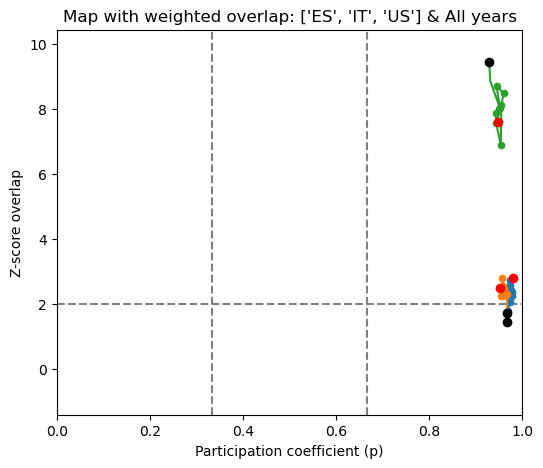

US
{'ES':            pc_w_out  z_out_overl
1986-1988  0.966955     1.459515
1989-1991  0.966680     1.665722
1992-1994  0.969888     1.800410
1995-1997  0.973761     2.082585
1998-2000  0.974562     2.405608
2001-2003  0.975170     2.606743
2004-2006  0.974025     2.738490
2007-2009  0.976406     2.438465
2010-2012  0.978547     2.259784
2013-2015  0.978633     2.383123
2016-2018  0.978222     2.628861
2019-2021  0.979725     2.808006, 'IT':            pc_w_out  z_out_overl
1986-1988  0.967630     1.735751
1989-1991  0.967372     2.100340
1992-1994  0.968619     2.317838
1995-1997  0.965436     2.274651
1998-2000  0.960326     2.455838
2001-2003  0.959035     2.566929
2004-2006  0.957171     2.809818
2007-2009  0.958387     2.535050
2010-2012  0.957552     2.258526
2013-2015  0.954957     2.239678
2016-2018  0.954911     2.398266
2019-2021  0.953485     2.501599, 'US':            pc_w_out  z_out_overl
1986-1988  0.929294     9.445270
1989-1991  0.931868     8.863564
1992-1994  0.952594

In [12]:


def Country_map (dict_results, country_list, year_list= 'All', plt_flag=True):

    # Define start for All flags
    if country_list == 'All':
        country_list = list(dict_results[list(dict_results.keys())[0]].country)
        title_country = 'All countries'
    else: 
        title_country  = country_list
    
    if year_list == 'All':
        year_list = list(dict_results.keys())
        title_year  = 'All years'

    else: 
        title_year  = year_list

    # Define figure characteristics 
    if plt_flag == True :
        maxY_plot = max([max(dict_results[y].z_out_overl) for y in list_years])
        minY_plot = min([min(dict_results[y].z_out_overl) for y in list_years])

        fig_phase, ax = plt.subplots(figsize = (6,5))
        ax.axvline(x=1/3, color='grey', linestyle= '--', zorder =1)
        ax.axvline(x=2/3, color='grey', linestyle= '--', zorder = 1)
        ax.axhline(y=2, color='grey', linestyle= '--', zorder = 1)
        ax.set_xlim (0,1)
        ax.set_xlim (0,1)
        ax.set_ylim((minY_plot-1,maxY_plot+1))

        #
        ax.set_ylabel('Z-score overlap')
        ax.set_xlabel('Participation coefficient (p)')
        ax.set_title ('Map with weighted overlap: '+ str(title_country)+' & '+ str(title_year))

    # Iterate for countries:
    coords_dict = dict()

    for country in country_list:
        coords = pd.DataFrame()
        for y in year_list:
            to_add = dict_results[y].loc[(dict_results[y]['country']==country),('pc_w_out','z_out_overl')] 
            coords = pd.concat([coords,to_add])
        coords.index = year_list

        coords_dict[country] = coords
        if (plt_flag ==True):
            # Plot 
            ax.scatter(coords.pc_w_out.iloc[2:-2], coords.z_out_overl.iloc[2:-2],zorder = 2,s=20,label= coords.index)
            ax.plot(coords.pc_w_out, coords.z_out_overl,zorder = 2,label= coords.index)
            ax.scatter(coords.pc_w_out.iloc[0], coords.z_out_overl.iloc[0],zorder = 2,label= coords.index[0],color = 'black')
            ax.scatter(coords.pc_w_out.iloc[-1], coords.z_out_overl.iloc[-1],zorder = 2,label= coords.index[-1],color = 'red')
        
    plt.show()
    print(country)
    return coords_dict

# Coords dict 
coords_dict = Country_map(dict_results,country_list='All',year_list='All', plt_flag = True)
print(coords_dict)

pickle.dump(coords_dict, open('country_coords.p', 'wb'))


In [51]:
coords = Country_map(dict_results,country_list=['ES'],year_list='All', plt_flag = True, axis=ax)


plt.show()
print(coords)

in year
ES
{'ES':            pc_w_out  z_out_overl
1986-1988  0.966955     1.459515
1989-1991  0.966680     1.665722
1992-1994  0.969888     1.800410
1995-1997  0.973761     2.082585
1998-2000  0.974562     2.405608
2001-2003  0.975170     2.606743
2004-2006  0.974025     2.738490
2007-2009  0.976406     2.438465
2010-2012  0.978547     2.259784
2013-2015  0.978633     2.383123
2016-2018  0.978222     2.628861
2019-2021  0.979725     2.808006}
